In [1]:
import sys, os
#path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir, 'dir1')))
#print(os.getcwd())
parent_path = os.path.normpath(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
#print(path2add)
sys.path.append(parent_path)
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii")))

import json
import yaml
from underpinnings.OccupancyMap2 import OccupancyMap2, LidarMeasurement, ExactLidarMeasurement
import numpy as np
from gyrii.underpinnings.BayesianArray import BayesianArray

import json
import yaml

    
def dict_array_upend(mydict,key,elem):
    if key not in mydict:
        mydict[key]=[]
    mydict[key.append(elem)]

def load_sensor_log_file(fname):
    response=[]
    first_timestamp=0
    f=open(fname,'r')
    for line in f.readlines():        
        dat=json.loads(line)
        timestamp=dat["timestamp"]-first_timestamp
        response.append(dat)
        if first_timestamp==0:                        
            first_timestamp=timestamp
    return response,first_timestamp
        
sensor_log,first_timestamp=load_sensor_log_file("../to_study/sensor_log_20210501-135127.txt")

#mymap=OccupancyMap2.load_from_file("../to_study/local_map.npy")
mymap=OccupancyMap2.load_from_file("../local_map.npy")


In [2]:
from Gyrus import Gyrus
from TimeSeries import TimeSeries
import numpy as np
from gyrii.underpinnings.BayesianArray import BayesianArray

class PosePlotter(Gyrus):
    def __init__(self):
        self.x_dataseries=TimeSeries(title="Pose X",ylabel="X Position (m)")
        self.x_unc_dataseries=TimeSeries(title="Pose X Unc",ylabel="X Position Uncertainty (m)")
        self.y_dataseries=TimeSeries(title="Pose Y",ylabel="X Position (m)")
        self.y_unc_dataseries=TimeSeries(title="Pose Y Unc",ylabel="X Position Uncertainty (m)")
        self.theta_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle (radians)")
        self.theta_unc_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle Uncertainty (radians)")
        self.lx_dataseries=TimeSeries(title="Pose X",ylabel="X Position Lidar (m)")
        self.lx_unc_dataseries=TimeSeries(title="Pose X Unc",ylabel="X Lidar Position Uncertainty (m)")
        self.ly_dataseries=TimeSeries(title="Pose Y",ylabel="X Position Lidar (m)")
        self.ly_unc_dataseries=TimeSeries(title="Pose Y Unc",ylabel="X Lidar Position Uncertainty (m)")
        self.ltheta_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle (radians)")
        self.ltheta_unc_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle Uncertainty (radians)")
        self.ctheta_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle (radians)")
        self.ctheta_unc_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle Uncertainty (radians)")   
        self.motor_durations=TimeSeries(title="Motor Duration")
        self.bfield_times=[]
        self.bfields=[]
        self.poses=[]
        
        
        
    def read_message(self,message):
        if "latest_pose" in message and "timestamp" in message:
            if message["pose_notes"]!="pose_is_stable":
                return
            self.x_dataseries.append(message["timestamp"],message["latest_pose"]["vals"][0])
            self.x_unc_dataseries.append(message["timestamp"],np.sqrt(message["latest_pose"]["covariance"][0][0]))
            self.y_dataseries.append(message["timestamp"],message["latest_pose"]["vals"][1])
            self.y_unc_dataseries.append(message["timestamp"],np.sqrt(message["latest_pose"]["covariance"][1][1]))
            self.theta_dataseries.append(message["timestamp"],message["latest_pose"]["vals"][2])
            self.theta_unc_dataseries.append(message["timestamp"],np.sqrt(message["latest_pose"]["covariance"][2][2]))
            self.poses.append(BayesianArray.from_object(message["latest_pose"]))
        if "notes" in message and message["notes"]=="lidar":
            self.lx_dataseries.append(message["timestamp"],message["pose_measurement"]["vals"][0])
            self.lx_unc_dataseries.append(message["timestamp"],np.sqrt(message["pose_measurement"]["covariance"][0][0]))
            self.ly_dataseries.append(message["timestamp"],message["pose_measurement"]["vals"][1])
            self.ly_unc_dataseries.append(message["timestamp"],np.sqrt(message["pose_measurement"]["covariance"][1][1]))
            self.ltheta_dataseries.append(message["timestamp"],message["pose_measurement"]["vals"][2])
            self.ltheta_unc_dataseries.append(message["timestamp"],np.sqrt(message["pose_measurement"]["covariance"][2][2]))
        if "notes" in message and message["notes"]=="compass":
            self.ctheta_dataseries.append(message["timestamp"],message["pose_measurement"]["vals"][2])
            self.ctheta_unc_dataseries.append(message["timestamp"],np.sqrt(message["pose_measurement"]["covariance"][2][2]))
        if "magnetometer/b_field" in message:
            self.bfield_times.append(message["timestamp"])
            self.bfields.append(np.array(message["magnetometer/b_field"])    )  
        if "drive/motors_active" in message:
            if message["drive/motors_active"][3]< 100:
                self.motor_durations.append(message["timestamp"],message["drive/motors_active"][3])

        return []


plotters={}
plotters["pose"]=PosePlotter()

gyrii=[]
#gyrii.append(MotionEstimationGyrus(None))
#mcgyrus=MotionCalibGyrus()
#gyrii.append(mcgyrus)

for key in plotters:
    gyrii.append(plotters[key])

start_timestamp=sensor_log[0]["timestamp"]
inspect_messagename="none"

remove_messages=["po"]

for i in range(len(sensor_log)):    
    for m in remove_messages:
        if m in sensor_log[i]:            
            #print("removing {}".format(sensor_log[i]))            
            sensor_log[i].pop(m,None)
            #print("removing {}".format(sensor_log[i]))                      
    start_message=sensor_log[i]
    start_message["timestamp"]-=start_timestamp #rescale time to zero at start
    waiting_messages=[ start_message ]    
    while len(waiting_messages)!=0:
        on_message=waiting_messages.pop()
        if inspect_messagename in on_message:
            print(on_message)
        for g in gyrii:
            resp=g.read_message(on_message)
            if resp is not None:
                waiting_messages.extend(resp)

original number of poses 851
number of reduced poses 83


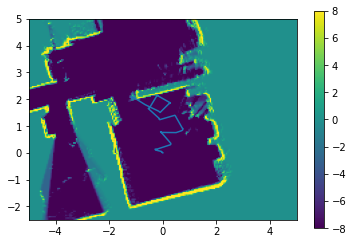

In [3]:
#create pose array
poses=plotters["pose"].poses
last_pose=BayesianArray()
sigma_cut=2
pose_xs=[]
pose_ys=[]
for i in range(len(poses)):
    chisq=poses[i].chi_square_from_pose(last_pose)
    #print("chisq {}".format(chisq))
    if chisq>sigma_cut:
        pose_xs.append(poses[i].vals[0])
        pose_ys.append(poses[i].vals[1])
    last_pose=poses[i]
print("original number of poses {}".format(len(poses)))
print("number of reduced poses {}".format(len(pose_xs)))

plottoshow=np.flip(mymap.gridmap_logodds,1).T
#plottoshow=np.flip(mymap.gridmap_logodds,1)

#posexy=np.dstack((plotters["pose"].x_dataseries.data,plotters["pose"].y_dataseries.data))[0]
posexy=np.dstack((pose_xs,pose_ys))[0]
#print(posexy)
import matplotlib.pyplot as plt
plt.figure()
startx=100
endx=300
#startx=0
#endx=400
starty=150
endy=300
res=0.05
mymap.resolution=res

plt.imshow(plottoshow[(400-endy):(400-starty),startx:endx],extent=[res*(startx-200),res*(endx-200),res*(starty-200),res*(endy-200)])
plt.colorbar()
#plt.plot(plotters["pose"].x_dataseries.data,plotters["pose"].y_dataseries.data)
plt.plot(pose_xs,pose_ys)
plt.show()



#plotters["pose"].x_dataseries.plot()
#plotters["pose"].y_dataseries.plot()
#plotters["pose"].theta_dataseries.plot()
#plt.figure()
#plt.xlim(10,14)
#plt.plot(plotters["pose"].theta_dataseries.times,plotters["pose"].theta_dataseries.data)
#plt.plot(plotters["pose"].ctheta_dataseries.times,plotters["pose"].ctheta_dataseries.data,'*')
#plt.show()
#plotters["pose"].x_unc_dataseries.plot()
#plotters["pose"].y_unc_dataseries.plot()
#plotters["pose"].theta_unc_dataseries.plot()

#plotters["pose"].motor_durations.plot()

it took 0.1745612621307373 s


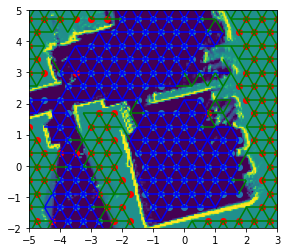

1702
1
1
1
1


In [4]:
from gyrii.underpinnings.GraphMap import GraphMap
from matplotlib import collections  as mc
import time


lattice_length=0.5
map_length=mymap.gridmap_logodds.shape[0]*mymap.resolution
graphmap=GraphMap(map_length,lattice_length)
start_time=time.time()
graphmap.describe_occupancy_map(mymap,search_range=3)
delta_time=time.time()-start_time
print("it took {} s".format(delta_time))

xys=graphmap.get_point_locations('free')
xs=xys[:,0]
ys=xys[:,1]
uxys=graphmap.get_point_locations('unknown')
uxs=uxys[:,0]
uys=uxys[:,1]
free_lines=graphmap.get_edge_locations('free')
frontier_lines=graphmap.get_edge_locations('unknown')
lc_free = mc.LineCollection(free_lines,color='blue') 
lc_frontier = mc.LineCollection(frontier_lines,color='green') 


fig,ax=plt.subplots()
ax.set_aspect(1)
plt.xlim(-5,3)
plt.ylim(-2,5)
#plt.xlim(-12,12)
#plt.ylim(-12,12)
plt.imshow(plottoshow[(400-endy):(400-starty),startx:endx],extent=[res*(startx-200),res*(endx-200),res*(starty-200),res*(endy-200)])
plt.scatter(xs,ys)
plt.scatter(uxs,uys,color='red')
ax.add_collection(lc_free)
ax.add_collection(lc_frontier)
plt.show()

from networkx.algorithms.components import connected_components
from networkx import triangular_lattice_graph,bfs_edges,subgraph_view,astar_path

passable_view=subgraph_view(graphmap.graph,filter_edge=lambda u,v: graphmap.graph.edges[(u,v)]['passable']!='blocked',filter_node=lambda u: graphmap.graph.nodes[u]['passable']=='unknown')
comps=connected_components(passable_view)
for c in comps:
    print(len(c))


(20, 23)
{'pos': array([ 0.25      , -0.04070786]), 'passable': 'free'}
dist 1.2827988316712111
{'pos': array([0.75      , 1.69134295]), 'passable': 'unknown'}
knknonwn nonde is (21, 27)
{'pos': array([0.75      , 1.69134295]), 'passable': 'unknown'}
count is 0
unknown node is (15, 34)


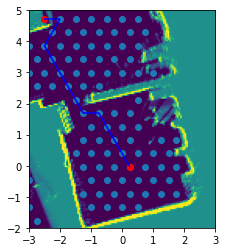

In [5]:
target_node=graphmap.get_node_nearest_to(np.array([0,0]))
txs=[ graphmap.graph.nodes[target_node]['pos'][0] ]
tys=[ graphmap.graph.nodes[target_node]['pos'][1] ]
print(target_node)
print(graphmap.graph.nodes[target_node])
print("dist {}".format( np.linalg.norm(graphmap.graph.nodes[target_node]['pos']-np.array([1,1]))  ))

#nearest_unknown_edge=graphmap.find_nearest_edge(target_node,'unknown')
unknown_node=graphmap.find_nearest_passable_node(target_node,'unknown')
print("knknonwn nonde is {}".format(unknown_node))
print(graphmap.graph.nodes[unknown_node])
count=graphmap.count_accessible_nodes(unknown_node,'unknown',max_count=10)
print("count is {}".format(count))

passable_view=subgraph_view(graphmap.graph,filter_edge=lambda u,v: graphmap.graph.edges[(u,v)]['passable']!='blocked',filter_node=lambda u: graphmap.graph.nodes[u]['passable']=='unknown')
comps=connected_components(passable_view)
unknown_node=graphmap.find_nearest_node_from_node_set(target_node,next(comps))
print("unknown node is {}".format(unknown_node))


target_pos=graphmap.graph.nodes[unknown_node]['pos']
txs.append(target_pos[0])
tys.append(target_pos[1])

#path_nodes=graphmap.astar_path(target_node,nearest_unknown_edge[0])
path_nodes=graphmap.astar_path(target_node,unknown_node)
path_lines=[]
last_node=None 
for p in path_nodes:
    if last_node is not None:
        path_lines.append([graphmap.graph.nodes[last_node]['pos'],graphmap.graph.nodes[p]['pos']])
    last_node=p
    
path_lc = mc.LineCollection(path_lines,color='blue') 

fig,ax=plt.subplots()
ax.set_aspect(1)
plt.xlim(-3,3)
plt.ylim(-2,5)
#plt.xlim(-12,12)
#plt.ylim(-12,12)
plt.imshow(plottoshow[(400-endy):(400-starty),startx:endx],extent=[res*(startx-200),res*(endx-200),res*(starty-200),res*(endy-200)])
plt.scatter(xs,ys)
plt.scatter(txs,tys,color='red')
ax.add_collection(path_lc)
#ax.add_collection(lc_frontier)
plt.show()

In [6]:
#Trash below here
#2d growing ,self organizing map
